In [33]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from tensorflow.keras.models import load_model

## Data Preprocessing

In [34]:
class_number = ["1", "2", "3", "4", "5"]
images_list = []
labels = []
# Loop through each class directory and augment images
for class_num in class_number:
    class_dir = os.path.join('/kaggle/input/fruits/train', class_num)

    # Loop through each image in the class directory
    for filename in os.listdir(class_dir):
        img_path = os.path.join(class_dir, filename)
        img = load_img(img_path, target_size=(128, 128))
        image = img_to_array(img)
        image = image / 255.0
        images_list.append(image)
        labels.append(int(class_num))

# Convert lists to numpy arrays
images_list = np.array(images_list)
labels = np.array(labels)

# Create a DataFrame
df = pd.DataFrame({'Image': list(images_list), 'Label': labels})

## Split Data

In [35]:
# Set a random seed
np.random.seed(42)

# Shuffle the data
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into train, validation, and test sets
train_df, test_df = train_test_split(df_shuffled, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.125, random_state=42)  # 0.125 x 0.8 = 0.1

# Separate data and labels for train, validation, and test sets
x_train = np.array(train_df['Image'].tolist())
y_train = np.array(train_df['Label'])

x_val = np.array(val_df['Image'].tolist())
y_val = np.array(val_df['Label'])

x_test = np.array(test_df['Image'].tolist())
y_test = np.array(test_df['Label'])

## Convert Data Into TensorFlow Form

In [36]:
# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train - 1, num_classes=5)
y_val = tf.keras.utils.to_categorical(y_val - 1, num_classes=5)
y_test = tf.keras.utils.to_categorical(y_test - 1, num_classes=5)

# Create TensorFlow Datasets
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

print('train_data size', len(train_data))
print('val_data size', len(val_data))
print('test_data size', len(test_data))

train_data size 6930
val_data size 990
test_data size 1980


## Build CNN model

## Train the model

In [37]:
model = Sequential()

model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.5))


#model.add(Conv2D(64, (3, 3), 1, padding='same', activation='relu'))
#model.add(MaxPooling2D())
#model.add(Dropout(0.5))


#model.add(Conv2D(32, (3, 3), 1, padding='same', activation='relu'))
#model.add(MaxPooling2D())
#model.add(Dropout(0.5))


model.add(Flatten())

model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.75))


model.add(Dense(5, activation='softmax'))

model.summary()
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 63, 63, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 63, 63, 16)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_22 (Dropout)        (None, 30, 30, 32)       

In [1]:
# Lists to store training and validation accuracy
train_accuracies = []
val_accuracies = []
# Training loop
epochs = 20
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    # Training
    train_accuracy = 0.0
    num_train_batches = 0

    for batch in train_data:
        images, labels = batch
        with tf.GradientTape() as tape:
            predictions = model(np.expand_dims(images, 0))
            predictions = tf.reshape(predictions, (5,))
            loss = tf.keras.losses.categorical_crossentropy(labels, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Accumulate training metrics
        train_accuracy += tf.reduce_mean(tf.keras.metrics.categorical_accuracy(labels, predictions))
        num_train_batches += 1

    # Average training metrics for the epoch
    train_accuracy /= num_train_batches

    # Validation
    val_accuracy = 0.0
    num_val_batches = 0
    for batch in val_data:
        images, labels = batch
        predictions = model(np.expand_dims(images, 0))
        predictions = tf.reshape(predictions, (5,))
        # Accumulate validation metrics
        val_accuracy += tf.reduce_mean(tf.keras.metrics.categorical_accuracy(labels, predictions))
        num_val_batches += 1

    # Average validation metrics for the epoch
    val_accuracy /= num_val_batches

    # Print and store metrics
    print(f"Training Accuracy: {train_accuracy.numpy()}")
    print(f"Validation Accuracy: {val_accuracy.numpy()}")

    # Append metrics for storage
    train_accuracies.append(train_accuracy.numpy())
    val_accuracies.append(val_accuracy.numpy())

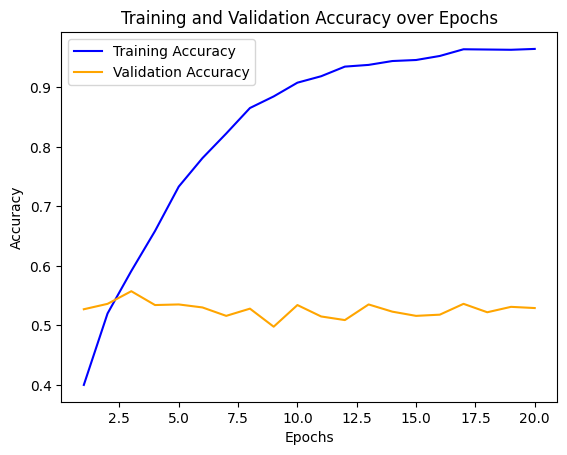

In [39]:
# Plot training and validation Accuracy graph
plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy', color='blue')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.show()

## Evaluate the model

In [40]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()
for batch in test_data.as_numpy_iterator(): 
    x, y = batch
    yhat = model(np.expand_dims(x, 0))
    yhat = tf.reshape(yhat, (5,))
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
print(f"Preision: {pre.result()}, Recall: {re.result()},Accuracy: { acc.result()}, ")

Preision: 0.5590386390686035, Recall: 0.5404040217399597,Accuracy: 0.5510100722312927, 


## Save the model

In [41]:
model.save(os.path.join('models','imageclassifier.h5'))

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Classify the testing images

In [42]:
# Load the model
new_model = load_model(os.path.join('models', 'imageclassifier.h5'))

directory_path = r'/kaggle/input/fruits/test'

# Get a list of all files in the directory
all_images = os.listdir(directory_path)

# Filter the list to include only files with certain extensions
image_names_without_extention = [os.path.splitext(file)[0] for file in all_images if file.lower().endswith(('.jpg', '.png', '.jpeg'))]

# Load and preprocess images
predictions = []
for image_name in all_images:
    image_path = os.path.join(directory_path, image_name)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))  # Resize to match the model input size
    img = img / 255.0  # Normalize pixel values to the range [0, 1]
    preds = new_model(np.expand_dims(img, 0))
    index_of_largest = np.argmax(preds, axis=1)
    predictions.extend(index_of_largest + 1)
    
# Convert predictions and image names to a DataFrame
df = pd.DataFrame({'image_id': image_names_without_extention, 'label': predictions})

# Save DataFrame to a CSV file
df.to_csv('predictions.csv', index=False)